# Setup

In [53]:
from random import random
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
!apt -qqq install graphviz

In [55]:
PROMOTIONAL = "PROMOTIONAL" # sacar un promocional en un 50/50 (ganar)
PERMANENT   = "PERMANENT"   # sacar un permanente en un 50/50 (perder)
GUARANTEED  = "GUARANTEED"  # sacar un promocional en un asegurado (ni ganar ni perder)

# Árbol de probabilidad

In [56]:
class Tree:

  def __init__(self, max_path = 6):

    self._max = max_path

    # Archivo para el grafo
    self._file = open("tree.dot", "w")
    self._file.write("digraph G {")

    # contador para nodos únicos
    self._id = 0

    # mapa con nombres internos => visibles de nodos
    self._names = {}

    # lista con todas las ramas del árbol
    self._paths = []

    # Contadores de 5*
    counters = {}
    counters[GUARANTEED] = 0
    counters[PROMOTIONAL] = 0
    counters[PERMANENT] = 0

    # Iniciar árbol
    self._tree(0, 0, False, counters=counters, latest=self.create_node("start"))
    self._file.write("}")
    self._file.close()

  def write(self, text):
    self._file.write(text)

  # Crea un nuevo nodo con un nombre visible, devuelve el nombre interno
  def create_node(self, label, color="white"):
    name = "node" + str(self._id)
    self.write(f"{name}[label=\"{label}\", style=\"filled\", fillcolor=\"{color}\"]")
    self._id += 1

    self._names[name] = label
    return name

  # Obtiene el nombre visible del nodo
  def get_node_label(self, name):
    return self._names[name]

  # Función recursiva:
  # - level: número de 5* sacados en la rama
  # - lost_count: cantidad de veces que se ha perdido un 50/50
  # - is_guaranteed: ¿en el nivel actual de la rama estamos en asegurado o en 50/50?
  # - counters: cantidad de 50/50 ganados, perdidos y asegurados que lleva la rama
  # - latest: Nodo anterior
  # - path: Lista con los nodos anteriores
  def _tree(self, level=0, lost_count=0, is_guaranteed=False, counters=None, latest=None, path=()):

    # El último nivel del camino imprime toda la rama guardada
    if level > self._max:
      self._paths.append(path)
      return


    if is_guaranteed: # Garantizado
      # En un garantizado, el siguiente siempre es promocional
      next_node = self.create_node(GUARANTEED + str(counters[GUARANTEED]), color="#0000FF40")
      self.write(f"{latest}->{next_node}[label=\"1\"]\n")

      next_map = counters.copy()
      next_map[GUARANTEED] += 1

      # En un garantizado, no hay 50/50, por lo que el contador de 50/50 no aumenta ni se reinicia
      self._tree(level + 1, lost_count, False, counters=next_map, latest=next_node, path=(*path, (next_node, 1)))

    else: # 50/50

      # La probabilidad real de un 50/50 depende del contador de 50/50 perdidos
      p_prom = 0.5
      if lost_count <= 1: # 0 y 1 perdidos: 50/50
        p_prom = 0.5
      elif lost_count == 2: # 2 perdidos: 75/25
        p_prom = 0.75
      else: # 3 perdidos: 100/0
        p_prom = 1

      # Ramificamos las dos posibilidades del 50/50: el siguiente es promocional,
      # o el siguiente es permanente.

      ## Rama promocional, o sea ganar el 50/50
      next_node = self.create_node(PROMOTIONAL + str(counters[PROMOTIONAL]), color="#00FF0040")
      self.write(f"{latest}->{next_node}[label=\"{p_prom}\"]\n")

      next_map = counters.copy()
      next_map[PROMOTIONAL] += 1

      # se reinicia el contador de 50/50 perdidos.
      self._tree(level + 1, 0, False, counters=next_map, latest=next_node, path=(*path, (next_node, p_prom)))


      ## Rama permanente, perder el 50/50
      next_node = self.create_node(PERMANENT + str(counters[PERMANENT]), color="#FF000040")
      self.write(f"{latest}->{next_node}[label=\"{1-p_prom}\"]\n")

      next_map = counters.copy()
      next_map[PERMANENT] += 1

      # Se incrementa el contador
      self._tree(level + 1, lost_count + 1, True, counters=next_map, latest=next_node, path=(*path, (next_node, 1-p_prom)))

  # Imprime todas las ramas en una tabla de probabilidades
  def get_paths_table(self):
    rows = []
    for path in self._paths:

      # Cuántos 50/50 ganados, perdidos y asegurados hay en cada camino
      counters = {}
      counters[GUARANTEED] = 0
      counters[PROMOTIONAL] = 0
      counters[PERMANENT] = 0

      probs = [] # Probabilidad condicional de cada nodo en la rama
      product = 1 # Probabilidad total de la rama
      for (node, prob) in path:
        probs.append(prob)
        product *= prob

        label = self.get_node_label(node)
        if label.startswith(GUARANTEED):
          counters[GUARANTEED] += 1
        elif label.startswith(PROMOTIONAL):
          counters[PROMOTIONAL] += 1
        else:
          counters[PERMANENT] += 1

      rows.append([counters[GUARANTEED], counters[PROMOTIONAL], counters[PERMANENT], *probs, product])

    df = pd.DataFrame(rows, columns=(GUARANTEED, PROMOTIONAL, PERMANENT, *[f"Level {i}" for i in range(self._max + 1)], "PRODUCT"))

    # Guaranteed representa los promocionales obtenidos con un asegurado
    df["Rel. Guaranteed"] = df[GUARANTEED] * df["PRODUCT"]
    # Promotional representa los personajes promocionales obtenidos GANANDO un 50/50
    df["Rel. Promotional"] = df[PROMOTIONAL] * df["PRODUCT"]
    # Permanent representa los 50/50 perdidos
    df["Rel. Permanent"] = df[PERMANENT] * df["PRODUCT"]

    df.to_csv("paths.csv")
    return df


In [57]:
result = Tree(6)

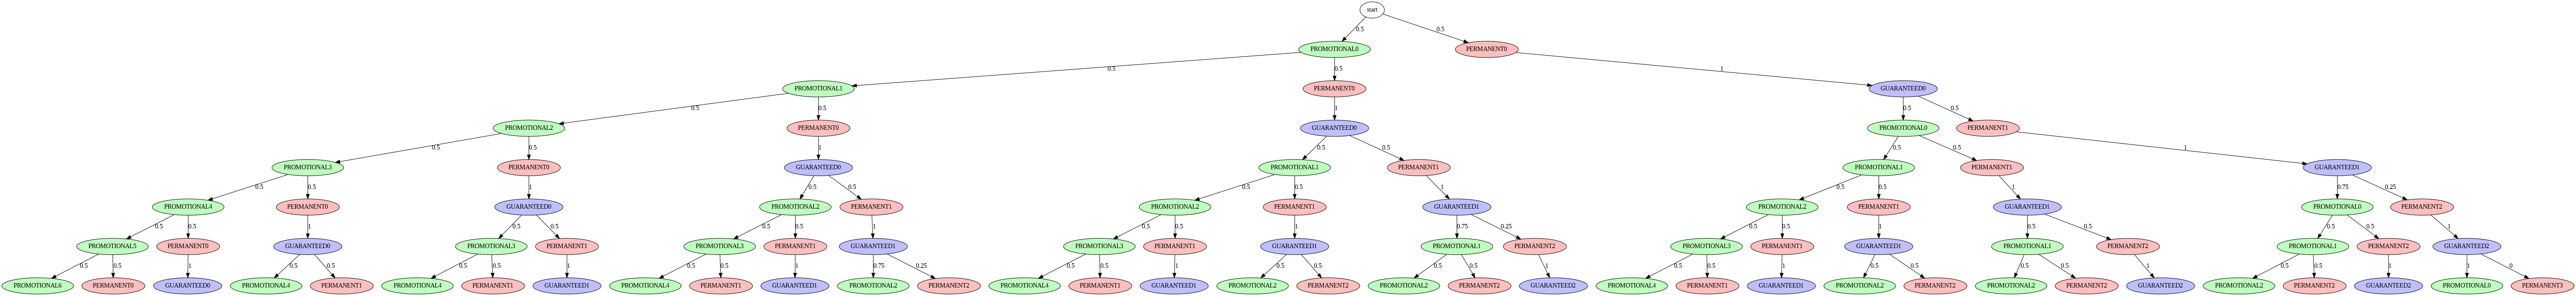

In [58]:
!dot -Tpng tree.dot > tree.png
Image("tree.png")

In [59]:
data = result.get_paths_table()
data

,GUARANTEED,PROMOTIONAL,PERMANENT,Level 0,Level 1,Level 2,Level 3,Level 4,Level 5,Level 6,PRODUCT,Rel. Guaranteed,Rel. Promotional,Rel. Permanent
0,0,7,0,0.5,0.5,0.5,0.5,0.50,0.50,0.50,0.007812,0.000000,0.054688,0.000000
1,0,6,1,0.5,0.5,0.5,0.5,0.50,0.50,0.50,0.007812,0.000000,0.046875,0.007812
2,1,5,1,0.5,0.5,0.5,0.5,0.50,0.50,1.00,0.015625,0.015625,0.078125,0.015625
3,1,5,1,0.5,0.5,0.5,0.5,0.50,1.00,0.50,0.015625,0.015625,0.078125,0.015625
4,1,4,2,0.5,0.5,0.5,0.5,0.50,1.00,0.50,0.015625,0.015625,0.062500,0.031250
5,1,5,1,0.5,0.5,0.5,0.5,1.00,0.50,0.50,0.015625,0.015625,0.078125,0.015625
6,1,4,2,0.5,0.5,0.5,0.5,1.00,0.50,0.50,0.015625,0.015625,0.062500,0.031250
7,2,3,2,0.5,0.5,0.5,0.5,1.00,0.50,1.00,0.031250,0.062500,0.093750,0.062500
8,1,5,1,0.5,0.5,0.5,1.0,0.50,0.50,0.50,0.015625,0.015625,0.078125,0.015625
9,1,4,2,0.5,0.5,0.5,1.0,0.50,0.50,0.50,0.015625,0.015625,0.062500,0.031250


In [60]:
def summarize(data, debug=False):
  rel_permanent = data["Rel. Permanent"].sum()
  rel_guaranteed = data["Rel. Guaranteed"].sum()
  rel_promotional = data["Rel. Promotional"].sum()

  rel_total = rel_permanent + rel_guaranteed + rel_promotional

  percent_permanent = rel_permanent / rel_total
  percent_guaranteed = rel_guaranteed / rel_total
  percent_promotional = rel_promotional / rel_total

  percent_5050 = percent_permanent + percent_promotional
  percent_5050_won = percent_promotional / percent_5050

  if debug:
    print(f"Rel. Permanent: {rel_permanent}")
    print(f"Rel. Guaranteed: {rel_guaranteed}")
    print(f"Rel. Promotional: {rel_promotional}")
    print(f"Rel. Total: {rel_total}")
    print()
    print(f"Percent Permanent: {percent_permanent}")
    print(f"Percent Guaranteed: {percent_guaranteed}")
    print(f"Percent Promotional: {percent_promotional}")
    print()
    print(f"Percent 50/50: {percent_5050}")
    print(f"Percent 50/50 Won: {percent_5050_won}")

  return float(percent_5050_won)

In [61]:
summarize(data, debug=True)

Rel. Permanent: 2.3359375
Rel. Guaranteed: 2.046875
Rel. Promotional: 2.6171875
Rel. Total: 7.0

Percent Permanent: 0.33370535714285715
Percent Guaranteed: 0.2924107142857143
Percent Promotional: 0.37388392857142855

Percent 50/50: 0.7075892857142857
Percent 50/50 Won: 0.528391167192429


0.528391167192429

In [62]:
# Ahora incrementando la cantidad
def won_per_pulls(max_level):
  result = Tree(max_level)
  data = result.get_paths_table()
  return summarize(data)

In [63]:
x_values = np.arange(1, 25)
y_values = [won_per_pulls(x) for x in x_values]


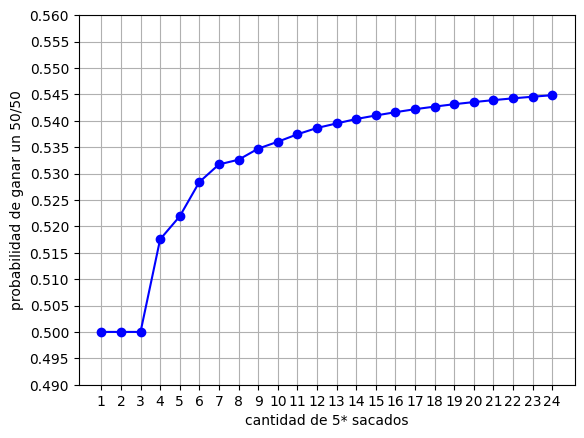

In [64]:
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.xlabel("cantidad de 5* sacados")
plt.ylabel("probabilidad de ganar un 50/50")
plt.xticks(np.arange(1, 25, 1))
plt.yticks(np.arange(0.49, 0.56, 0.005))
plt.grid(True)